# 0. Introduction

data: synchronized_brainwave_dataset.csv

row of data:

\#: the index of eath row

id: participant_id, integer value in the range of 1 to 30, means 30 participants.


indra_time: time of all stimulus events

browser_latency

reading_time

attention_esense: The Attention Meter algorithm indicates the intensity of mental “focus” or “attention.” The value ranges from 0 to 100. The attention level increases when a user focuses on a single thought or an external object, and decreases when distracted.(https://neurosky.com/biosensors/eeg-sensor/algorithms/)

meditation_esense: The Meditation Meter algorithm indicates the level of mental “calmness” or “relaxation.” The value ranges from 0 to 100, and increases when users relax the mind and decreases when they are uneasy or stressed.(https://neurosky.com/biosensors/eeg-sensor/algorithms/)

eeg_power: Tuple represents the magnitude of 8 commonly-recognized types of EEG frequency bands -- delta (0.5 - 2.75Hz), theta (3.5 - 6.75Hz), low-alpha (7.5 - 9.25Hz), high-alpha (10 - 11.75Hz), low-beta (13 - 16.75Hz), high-beta (18 - 29.75Hz), low-gamma (31 - 39.75Hz), and mid-gamma (41 - 49.75Hz). These values have no units and are only meaningful for comparison to the values for the other frequency bands within a sample.(https://courses.ischool.berkeley.edu/i290-shda/f14/ColorCountingChallenge/)

raw_values: Tuple containing raw sample values acquired by the sensor

signal_quality: A signal quality of 0 is optimal. Values over 128 indicate that the headset was placed incorrectly.

createdAt: when data were created

updatedAt: when data were updated

label: Indicate what the participant is doing.

The device only has one electrode and it is placed roughly at fp1, according to the dataset creator.(https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset/discussion/284896)


# 1. Baseline

In this baseline, we want to classify labels math and relax using column raw_data. We have 934 rows of data for relax and 936 rows for math. Each row has a raw_data column which is a 512 length list, this 512 length list acts as feature in our model.


In [400]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tsgm
from tsgm.models.architectures.zoo import zoo  
from tensorflow.keras.utils import to_categorical
import ast
import baseline
%matplotlib inline

In [401]:
X, y = tsgm.utils.get_synchronized_brainwave_dataset()
print('feature shape in total data:',X.shape)
print('label shape in total data:',y.shape)

INFO:utils:File exist


feature shape in total data: (30013, 12)
label shape in total data: (30013,)


In [402]:
df = pd.read_csv("../data/synchronized_brainwave_dataset.csv")

In [403]:
# we want to classify label 'relax' and 'math'
relax = df[df.label == 'relax']
math = df[(df.label == 'math1') |
          (df.label == 'math2') |
          (df.label == 'math3') |
          (df.label == 'math4') |
          (df.label == 'math5') |
          (df.label == 'math6') |
          (df.label == 'math7') |
          (df.label == 'math8') |
          (df.label == 'math9') |
          (df.label == 'math10') |
          (df.label == 'math11') |
          (df.label == 'math12') ]

print('length of relax data:',len(relax))
print('length of math data',len(math))

length of relax data: 934
length of math data 936


In [404]:
relax_math = pd.concat([relax, math], axis=0)
relax_math = relax_math[relax_math['signal_quality'] < 128]
relax_math

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
13274,26880,7,2015-05-09 23:32:53.910,14,2015-05-09 16:32:54.000,80,61,"[5044.0, 10156.0, 3281.0, 10403.0, 12393.0, 10...","[285.0, 241.0, 200.0, 161.0, 129.0, 90.0, 33.0...",0,2015-05-09 23:32:54.049,2015-05-09 23:32:54.049+00,relax
13275,2427,11,2015-05-09 23:32:53.915,-171,2015-05-09 16:32:54.135,56,40,"[548188.0, 67192.0, 20298.0, 4142.0, 30576.0, ...","[-12.0, -60.0, -70.0, -74.0, -129.0, -183.0, -...",0,2015-05-09 23:32:54.361,2015-05-09 23:32:54.361+00,relax
13276,24351,5,2015-05-09 23:32:54.072,1022,2015-05-09 16:32:53.057,13,48,"[449571.0, 83093.0, 15379.0, 34656.0, 6750.0, ...","[37.0, 43.0, 42.0, 25.0, 12.0, 25.0, 42.0, 48....",0,2015-05-09 23:32:52.093,2015-05-09 23:32:52.093+00,relax
13277,537,1,2015-05-09 23:32:54.153,13404,2015-05-09 16:32:40.884,51,67,"[85497.0, 20547.0, 2723.0, 3270.0, 2522.0, 220...","[17.0, 19.0, 23.0, 25.0, 27.0, 38.0, 51.0, 52....",0,2015-05-09 23:32:27.535,2015-05-09 23:32:27.535+00,relax
13278,4859,13,2015-05-09 23:32:54.303,-297,2015-05-09 16:32:54.779,60,66,"[72768.0, 44080.0, 25974.0, 16079.0, 12995.0, ...","[99.0, 69.0, 9.0, -4.0, 16.0, 16.0, 17.0, 27.0...",0,2015-05-09 23:32:55.141,2015-05-09 23:32:55.141+00,relax
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23828,15941,24,2015-05-09 23:44:55.969,"-1,572",2015-05-09 16:44:57.759,40,50,"[2159489.0, 136563.0, 55872.0, 9777.0, 11819.0...","[35.0, -28.0, 2.0, -3.0, -21.0, -12.0, 56.0, 5...",0,2015-05-09 23:44:59.426,2015-05-09 23:44:59.426+00,math12
23829,16597,25,2015-05-09 23:44:56.126,-226,2015-05-09 16:44:57.309,43,67,"[29164.0, 13290.0, 11052.0, 6885.0, 3829.0, 48...","[28.0, 1.0, 5.0, 38.0, 60.0, 60.0, 55.0, 57.0,...",0,2015-05-09 23:44:57.594,2015-05-09 23:44:57.594+00,math12
23830,8748,16,2015-05-09 23:44:56.185,-54,2015-05-09 16:44:56.272,34,40,"[35542.0, 32228.0, 1920.0, 2826.0, 3165.0, 162...","[106.0, 108.0, 91.0, 81.0, 72.0, 68.0, 67.0, 6...",0,2015-05-09 23:44:56.388,2015-05-09 23:44:56.388+00,math12
23831,18331,27,2015-05-09 23:44:56.271,-922,2015-05-09 16:44:57.324,94,11,"[577033.0, 21286.0, 11050.0, 6076.0, 10917.0, ...","[48.0, 37.0, 18.0, -3.0, -14.0, -14.0, 22.0, 7...",0,2015-05-09 23:44:58.320,2015-05-09 23:44:58.32+00,math12


In [408]:
# Convert lable and data type, we use raw_values and eeg_power as features
df = relax_math
df['label'] = df['label'].apply(lambda x: 'relax' if x == 'relax' else 'math')
# df_selected = df[['label', 'raw_values', 'eeg_power']]
df_relax_math = pd.concat([df['label'], df['raw_values'], df['eeg_power']], axis=1)
df_relax_math['raw_values'] = df_relax_math['raw_values'].str.replace('[\[\]]', '', regex=True)
df_relax_math['raw_values'] = df_relax_math['raw_values'].apply(lambda x: list(map(float, x.split(','))))
df_relax_math['eeg_power'] = df_relax_math['eeg_power'].str.replace('[\[\]]', '', regex=True)
df_relax_math['eeg_power'] = df_relax_math['eeg_power'].apply(lambda x: list(map(float, x.split(','))))
df_relax_math

,label,raw_values,eeg_power
13274,relax,"[285.0, 241.0, 200.0, 161.0, 129.0, 90.0, 33.0...","[5044.0, 10156.0, 3281.0, 10403.0, 12393.0, 10..."
13275,relax,"[-12.0, -60.0, -70.0, -74.0, -129.0, -183.0, -...","[548188.0, 67192.0, 20298.0, 4142.0, 30576.0, ..."
13276,relax,"[37.0, 43.0, 42.0, 25.0, 12.0, 25.0, 42.0, 48....","[449571.0, 83093.0, 15379.0, 34656.0, 6750.0, ..."
13277,relax,"[17.0, 19.0, 23.0, 25.0, 27.0, 38.0, 51.0, 52....","[85497.0, 20547.0, 2723.0, 3270.0, 2522.0, 220..."
13278,relax,"[99.0, 69.0, 9.0, -4.0, 16.0, 16.0, 17.0, 27.0...","[72768.0, 44080.0, 25974.0, 16079.0, 12995.0, ..."
...,...,...,...
23828,math,"[35.0, -28.0, 2.0, -3.0, -21.0, -12.0, 56.0, 5...","[2159489.0, 136563.0, 55872.0, 9777.0, 11819.0..."
23829,math,"[28.0, 1.0, 5.0, 38.0, 60.0, 60.0, 55.0, 57.0,...","[29164.0, 13290.0, 11052.0, 6885.0, 3829.0, 48..."
23830,math,"[106.0, 108.0, 91.0, 81.0, 72.0, 68.0, 67.0, 6...","[35542.0, 32228.0, 1920.0, 2826.0, 3165.0, 162..."
23831,math,"[48.0, 37.0, 18.0, -3.0, -14.0, -14.0, 22.0, 7...","[577033.0, 21286.0, 11050.0, 6076.0, 10917.0, ..."


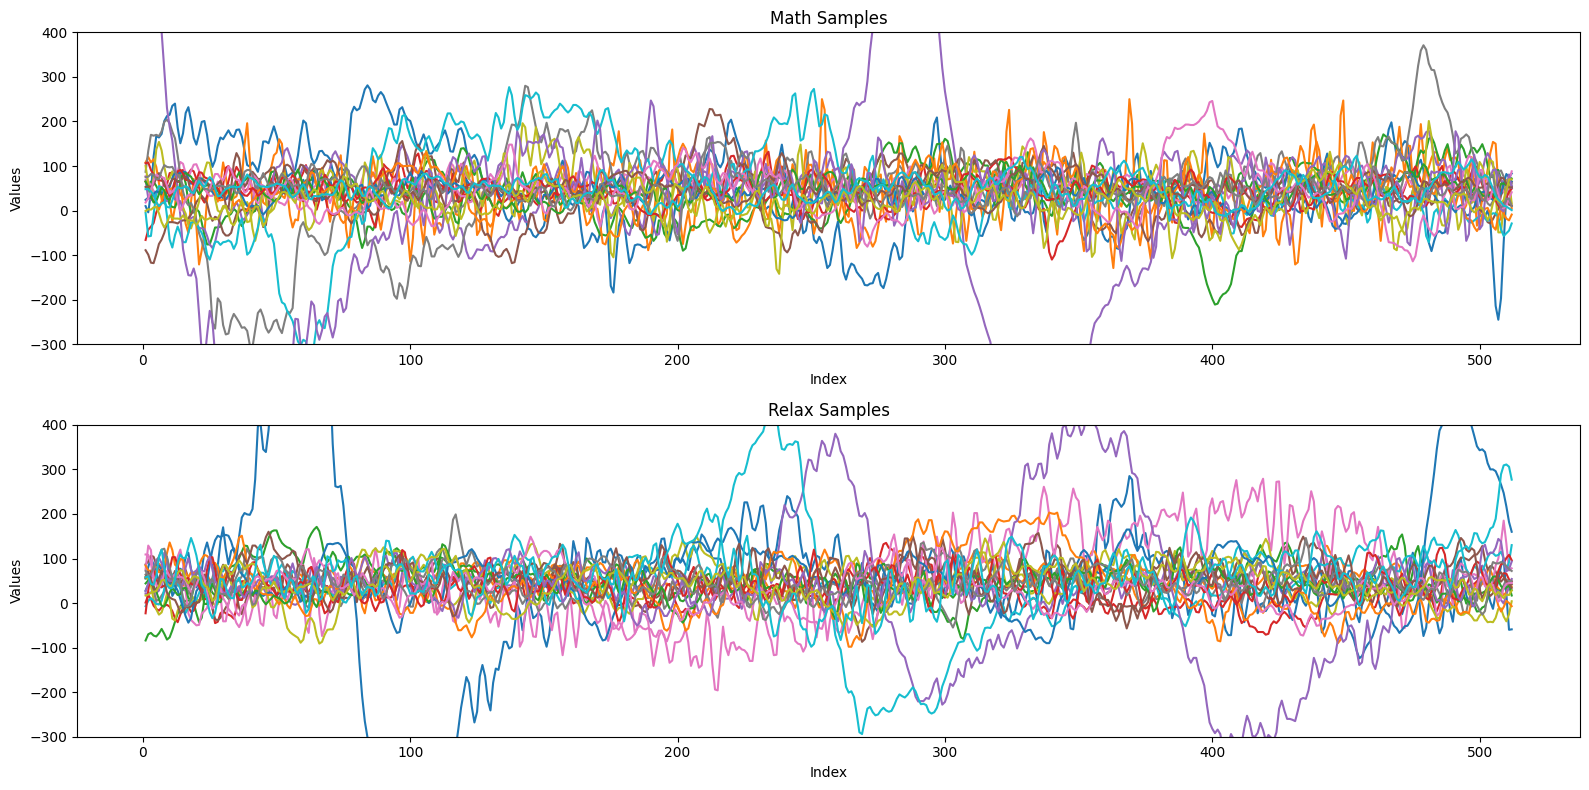

In [409]:
# visualize 10 sample data using raw_values
math_samples = df_relax_math[df_relax_math['label'] == 'math'].sample(20)
relax_samples = df_relax_math[df_relax_math['label'] == 'relax'].sample(20)
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)  
for idx, row in math_samples.iterrows():
    x_axis = range(1, len(row['raw_values']) + 1)
    plt.plot(x_axis, row['raw_values'], label=f'Sample {idx}')
plt.title('Math Samples')
plt.xlabel('Index')
plt.ylabel('Values')
# plt.legend()
plt.ylim(-300, 400)

plt.subplot(2, 1, 2)  
for idx, row in relax_samples.iterrows():
    x_axis = range(1, len(row['raw_values']) + 1)
    plt.plot(x_axis, row['raw_values'], label=f'Sample {idx}')
plt.title('Relax Samples')
plt.xlabel('Index')
plt.ylabel('Values')
# plt.legend()
plt.ylim(-300, 400)

plt.tight_layout()
plt.show()

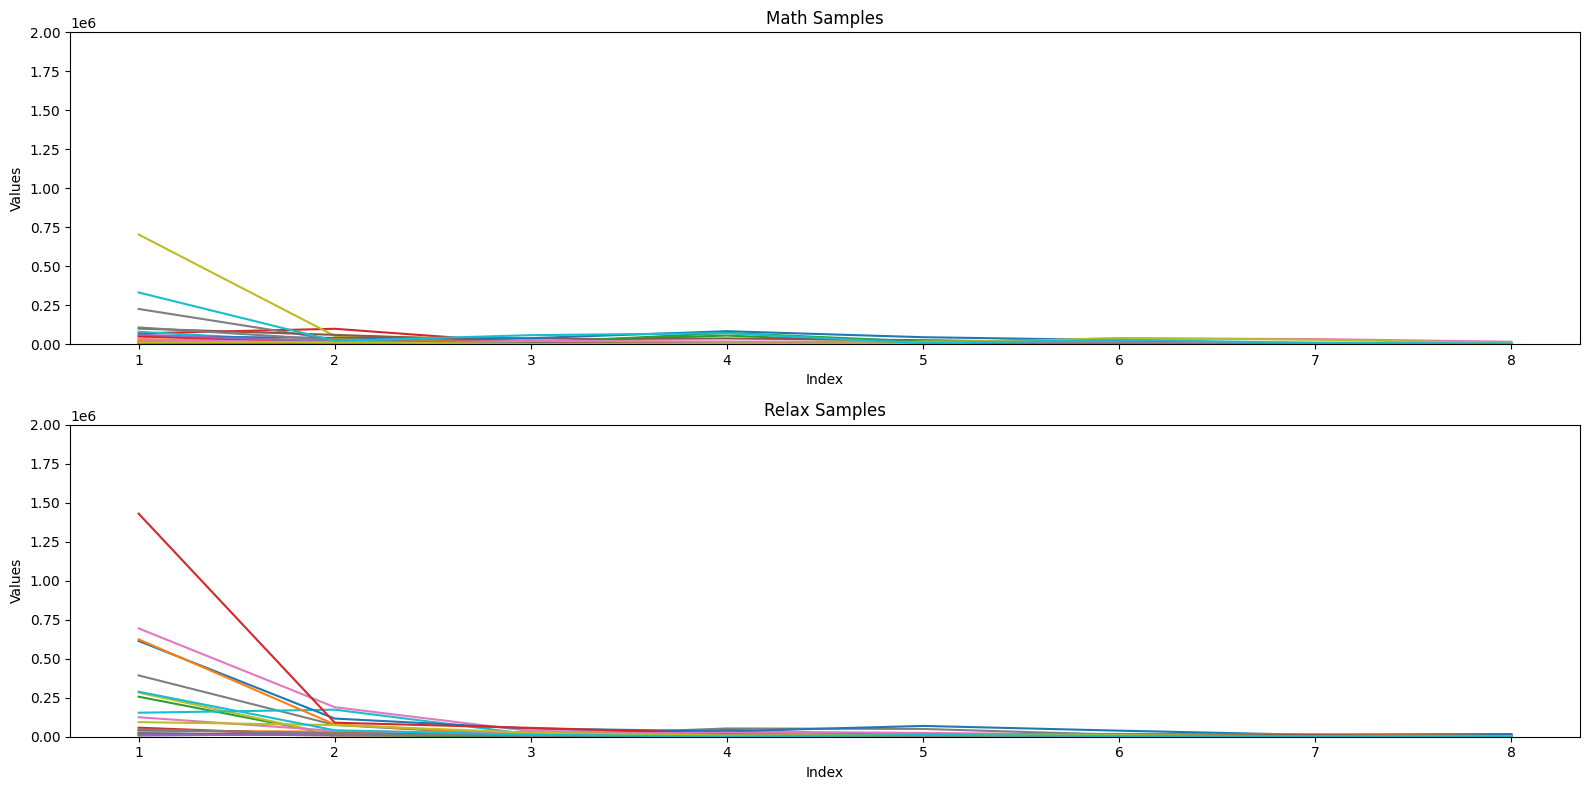

In [410]:
# visualize 10 sample data using eeg_power
math_samples = df_relax_math[df_relax_math['label'] == 'math'].sample(20)
relax_samples = df_relax_math[df_relax_math['label'] == 'relax'].sample(20)
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)  
for idx, row in math_samples.iterrows():
    x_axis = range(1, len(row['eeg_power']) + 1)
    plt.plot(x_axis, row['eeg_power'], label=f'Sample {idx}')
plt.title('Math Samples')
plt.xlabel('Index')
plt.ylabel('Values')
# plt.legend()
plt.ylim(0, 2e6)

plt.subplot(2, 1, 2)  
for idx, row in relax_samples.iterrows():
    x_axis = range(1, len(row['eeg_power']) + 1)
    plt.plot(x_axis, row['eeg_power'], label=f'Sample {idx}')
plt.title('Relax Samples')
plt.xlabel('Index')
plt.ylabel('Values')
# plt.legend()
plt.ylim(0, 2e6)

plt.tight_layout()
plt.show()

In [411]:
df_relax_math['label'] = df_relax_math['label'].map({'relax': 1, 'math': 0})
df_relax_math

,label,raw_values,eeg_power
13274,1,"[285.0, 241.0, 200.0, 161.0, 129.0, 90.0, 33.0...","[5044.0, 10156.0, 3281.0, 10403.0, 12393.0, 10..."
13275,1,"[-12.0, -60.0, -70.0, -74.0, -129.0, -183.0, -...","[548188.0, 67192.0, 20298.0, 4142.0, 30576.0, ..."
13276,1,"[37.0, 43.0, 42.0, 25.0, 12.0, 25.0, 42.0, 48....","[449571.0, 83093.0, 15379.0, 34656.0, 6750.0, ..."
13277,1,"[17.0, 19.0, 23.0, 25.0, 27.0, 38.0, 51.0, 52....","[85497.0, 20547.0, 2723.0, 3270.0, 2522.0, 220..."
13278,1,"[99.0, 69.0, 9.0, -4.0, 16.0, 16.0, 17.0, 27.0...","[72768.0, 44080.0, 25974.0, 16079.0, 12995.0, ..."
...,...,...,...
23828,0,"[35.0, -28.0, 2.0, -3.0, -21.0, -12.0, 56.0, 5...","[2159489.0, 136563.0, 55872.0, 9777.0, 11819.0..."
23829,0,"[28.0, 1.0, 5.0, 38.0, 60.0, 60.0, 55.0, 57.0,...","[29164.0, 13290.0, 11052.0, 6885.0, 3829.0, 48..."
23830,0,"[106.0, 108.0, 91.0, 81.0, 72.0, 68.0, 67.0, 6...","[35542.0, 32228.0, 1920.0, 2826.0, 3165.0, 162..."
23831,0,"[48.0, 37.0, 18.0, -3.0, -14.0, -14.0, 22.0, 7...","[577033.0, 21286.0, 11050.0, 6076.0, 10917.0, ..."


In [412]:
X_raw = df_relax_math['raw_values']
X_eeg = df_relax_math['eeg_power']
X_enhanced = pd.concat([X_raw, df_relax_math['eeg_power']], axis=1)
X = X_raw
y = df_relax_math['label']


In [413]:
print('feature shape:', X.shape)
print('label shape:', y.shape)
# print(X.head())

feature shape: (1870,)
label shape: (1870,)


In [414]:
X_array = np.array(X.tolist())
print('Converted X shape:', X_array.shape)

Converted X shape: (1870, 512)


In [415]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_array, y, test_size=0.2, random_state=42)

In [416]:
print(X_train.shape)
print(y_train.shape)

(1496, 512)
(1496,)


## 1.0 Reshape data

In [417]:
seq_len = 512  # Number of timesteps per sequence
feat_dim = 1  # Number of features per timestep, we only have 1 sensor
output_dim = 1  # For binary classification

X_train_ts = X_train.reshape(-1, seq_len, feat_dim) 
X_val_ts = X_val.reshape(-1, seq_len, feat_dim)

print('X_train_ts shape:', X_train_ts.shape)
print('X_val_ts shape:', X_val_ts.shape)
print('y_train shape', y_train.shape)

X_train_ts shape: (1496, 512, 1)
X_val_ts shape: (374, 512, 1)
y_train shape (1496,)


In [423]:
# scale data to [-1, 1]
X_min = X_train_ts.min(axis=(0,1), keepdims=True)
X_max = X_train_ts.max(axis=(0,1), keepdims=True)
X_train_ts_scaled = 2 * ((X_train_ts - X_min) / (X_max - X_min)) - 1

## 1.1 Time series model clf_cn

In [424]:
model_ts_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts = model_ts_architecture.model

# Model init
model_ts.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model training
history_ts = model_ts.fit(
    X_train_ts, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [425]:
val_loss_ts, val_acc_ts = model_ts.evaluate(X_val_ts, y_val)
print('val loss in ts model:', val_loss_ts)
print("val accuracy in ts model:", val_acc_ts)

12/12 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5214
val loss in ts model: 0.693753182888031
val accuracy in ts model: 0.5213903784751892


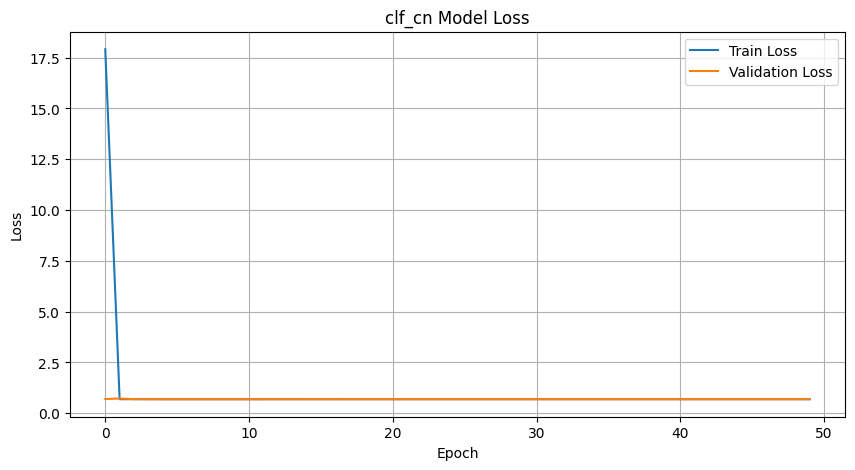

In [426]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['loss'], label='Train Loss')
plt.plot(history_ts.history['val_loss'], label='Validation Loss')
plt.title('clf_cn Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

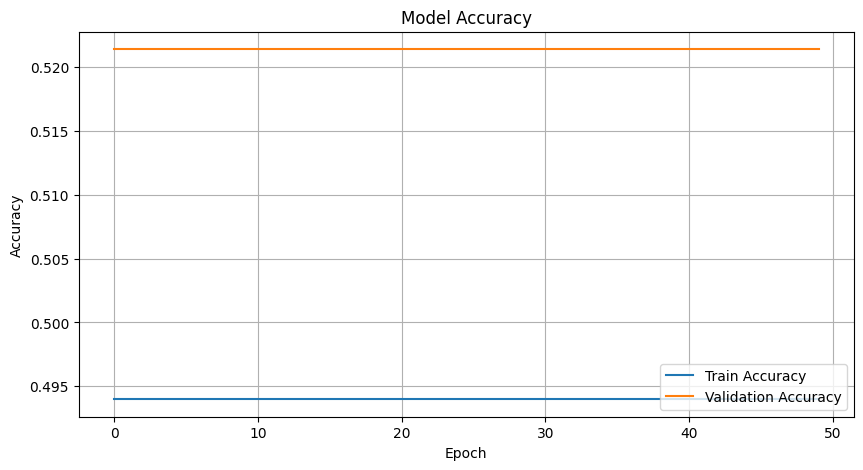

In [427]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['accuracy'], label='Train Accuracy')
plt.plot(history_ts.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.2 Sequential model

In [428]:
#init model
model = Sequential([
    Dense(10, activation='relu', input_shape=(512,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss='sparse_categorical_crossentropy', 
              metrics=['binary_accuracy'])

# train model
history = model.fit(
    X_train_ts, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)


In [429]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print('val loss in normal model:', val_loss)
print("val accuracy in normal model:", val_acc)

12/12 [==============================] - 0s 547us/step - loss: 0.7837 - binary_accuracy: 0.5160
val loss in normal model: 0.7836863994598389
val accuracy in normal model: 0.5160427689552307


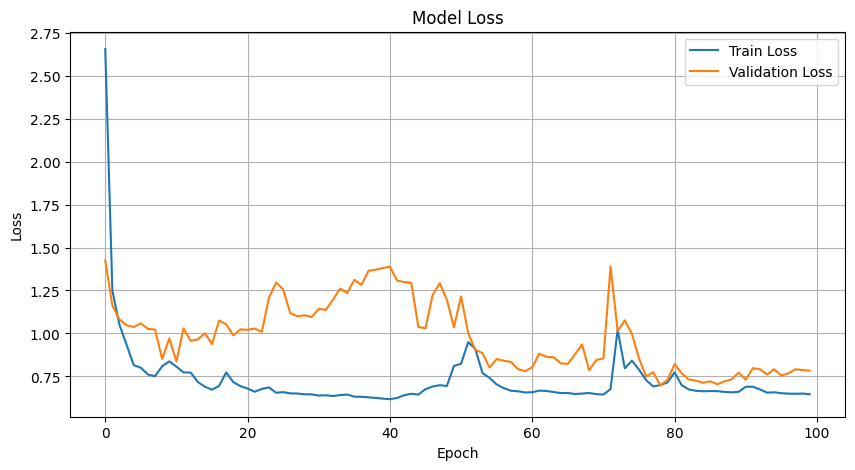

In [430]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

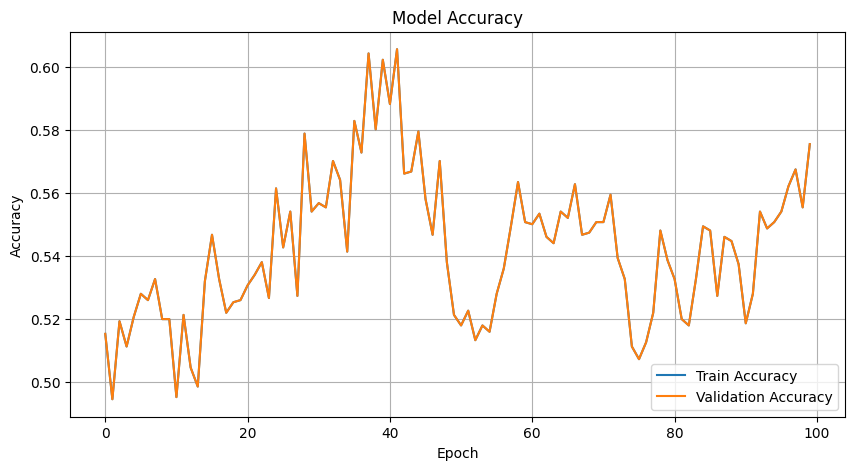

In [431]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.3 Transformer model

In [432]:
seq_len = 512
feat_dim = 1
num_heads = 4 
ff_dim = 64 
n_blocks = 2
dropout_rate = 0.1  
output_dim = 1

model_transformer = tsgm.models.architectures.zoo['clf_transformer'](
    seq_len, feat_dim, num_heads, ff_dim, n_blocks, dropout_rate, output_dim
).model


In [433]:
# init model
model_transformer.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# train model
history = model_transformer.fit(
    X_train_ts,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [434]:
# print(history.history.keys())

# print("Training and validation loss and accuracy per epoch:")
for i in range(0, len(history.history['loss']), 1):
    print(f"Epoch {i+1}:")
    print(f"  Training Loss:     {history.history['loss'][i]}")
    print(f"  Validation Loss:   {history.history['val_loss'][i]}")
    print(f"  Training Accuracy: {history.history['accuracy'][i]}")
    print(f"  Validation Accuracy: {history.history['val_accuracy'][i]}")

Epoch 1:
  Training Loss:     0.6932426691055298
  Validation Loss:   0.6934274435043335
  Training Accuracy: 0.4939839541912079
  Validation Accuracy: 0.5213903784751892
Epoch 2:
  Training Loss:     0.693153440952301
  Validation Loss:   0.6934137344360352
  Training Accuracy: 0.4939839541912079
  Validation Accuracy: 0.5213903784751892
Epoch 3:
  Training Loss:     0.6931399703025818
  Validation Loss:   0.693463146686554
  Training Accuracy: 0.4939839541912079
  Validation Accuracy: 0.5213903784751892
Epoch 4:
  Training Loss:     0.6931396126747131
  Validation Loss:   0.6937088370323181
  Training Accuracy: 0.4939839541912079
  Validation Accuracy: 0.5213903784751892
Epoch 5:
  Training Loss:     0.6931712627410889
  Validation Loss:   0.6939430236816406
  Training Accuracy: 0.4939839541912079
  Validation Accuracy: 0.5213903784751892
Epoch 6:
  Training Loss:     0.6931650638580322
  Validation Loss:   0.6935959458351135
  Training Accuracy: 0.4939839541912079
  Validation Accur

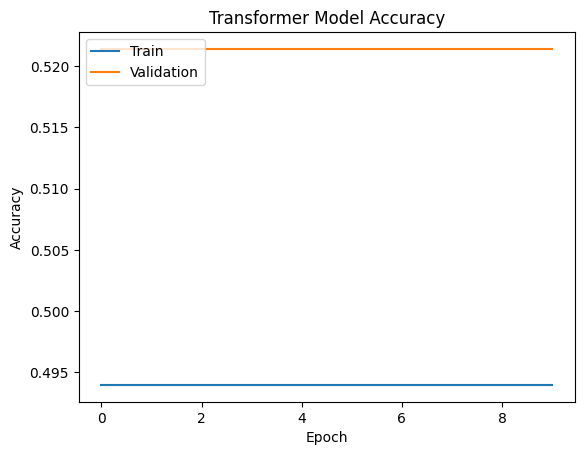

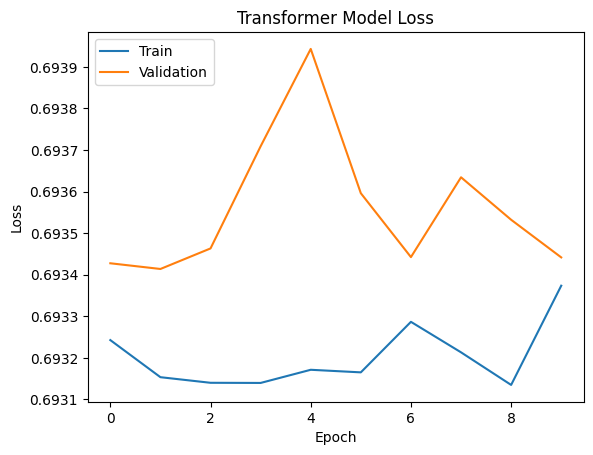

In [435]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 2. Augmentations

augment X_train_ts and y_train using GAN

## 2.0 Parameters and data perpare

In [ ]:
# seq_len = 512
# feat_dim = 1
batch_size = 128
latent_dim = 64
# output_dim = 1


In [478]:
# todo: do we need to scale X and why?

X_train_ts_scaled_32 = X_train_ts_scaled.astype(np.float32)
X_train_ts_32 = X_train_ts.astype(np.float32)
# convert y to float32 and one-hot
y_train_32 = y_train.astype(np.float32)
y_train_onehot = to_categorical(y_train, num_classes=2)
y_train_onehot_32 = y_train_onehot.astype(np.float32)

## 2.1 cgan_base_c4_l1

In [440]:
# init model
dataset = tf.data.Dataset.from_tensor_slices((X_train_ts_32, y_train_onehot))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feat_dim,
    latent_dim=latent_dim, output_dim=2)
discriminator, generator = architecture.discriminator, architecture.generator
# todo: why we need latent_dim again?
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    g_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, labels=y_train_32, save_path="./tmp")

# train model
cond_gan.fit(dataset, epochs=5, callbacks=[cbk], verbose=0)

InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [3,64] vs. shape[1] = [3] [Op:ConcatV2]

In [ ]:
cond_gan.fit(dataset, epochs=5, callbacks=[cbk], verbose=0)

## 2.2 GaussianNoise

In [ ]:
# X_train_ts_scaled.shape

In [442]:
gn_aug = tsgm.models.augmentations.GaussianNoise()
n_gen = 1024
X_y_gen = gn_aug.generate(X=X_train_ts, y=y_train_onehot, n_samples=n_gen)

In [443]:
print('generated feature shape:', X_y_gen[0].shape)
print('generated label shape:', X_y_gen[1].shape)

generated feature shape: (1024, 512, 1)
generated label shape: (1024, 2)


Add generated data to X_train_ts, y_train_onehot and shuffle, the original data size is around 1500, generated data size is around 1000.


In [444]:
# concate and shuffle
X_combined = np.concatenate([X_train_ts, X_y_gen[0]], axis=0)
y_combined = np.concatenate([y_train_onehot, X_y_gen[1]], axis=0)
shuffled_indices = np.random.permutation(X_combined.shape[0])

X_gn = X_combined[shuffled_indices]
y_gn_onehot = y_combined[shuffled_indices]
# convert to 1-dim binary label
y_gn = np.argmax(y_gn_onehot, axis=1)

In [445]:
print("Shape of combined and shuffled features:", X_gn.shape)
print("Shape of combined and shuffled labels:", y_gn.shape)

Shape of combined and shuffled features: (2520, 512, 1)
Shape of combined and shuffled labels: (2520,)


### 2.2.1 clf_cn model

In [446]:
# train with clf_cn model
model_ts_gn_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts_gn = model_ts_gn_architecture.model

model_ts_gn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model training
history_ts_gn = model_ts_gn.fit(
    X_gn, y_gn,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [447]:
val_loss_ts_gn, val_acc_ts_gn = model_ts_gn.evaluate(X_val_ts, y_val)
print('val loss in ts_gn model:', val_loss_ts_gn)
print("val accuracy in ts_gn model:", val_acc_ts_gn)

12/12 [==============================] - 0s 2ms/step - loss: 3.8565 - accuracy: 0.5214
val loss in ts_gn model: 3.856522560119629
val accuracy in ts_gn model: 0.5213903784751892


### 2.2.2 Sequential model

In [452]:
#init model
model_sq_gn = Sequential([
    Dense(10, activation='relu', input_shape=(512,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_sq_gn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss='sparse_categorical_crossentropy', 
              metrics=['binary_accuracy'])

# train model
history_sq_gn = model_sq_gn.fit(
    X_gn, y_gn,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)

In [454]:
val_loss, val_acc = model_sq_gn.evaluate(X_val, y_val)
print('val loss in sq_gn model:', val_loss)
print("val accuracy in sq_gn model:", val_acc)

12/12 [==============================] - 0s 509us/step - loss: 0.9248 - binary_accuracy: 0.5321
val loss in sq_gn model: 0.9248221516609192
val accuracy in sq_gn model: 0.5320855379104614


### 2.2.3 transformer

In [455]:
# train model
history_transf_gn = model_transformer.fit(
    X_gn,
    y_gn,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [456]:
for i in range(0, len(history_transf_gn.history['loss']), 1):
    print(f"Epoch {i+1}:")
    print(f"  Training Loss:     {history_transf_gn.history['loss'][i]}")
    print(f"  Validation Loss:   {history_transf_gn.history['val_loss'][i]}")
    print(f"  Training Accuracy: {history_transf_gn.history['accuracy'][i]}")
    print(f"  Validation Accuracy: {history_transf_gn.history['val_accuracy'][i]}")

Epoch 1:
  Training Loss:     7.8969292640686035
  Validation Loss:   0.6935141086578369
  Training Accuracy: 0.48259493708610535
  Validation Accuracy: 0.5213903784751892
Epoch 2:
  Training Loss:     7.896928310394287
  Validation Loss:   0.6935139894485474
  Training Accuracy: 0.48167192935943604
  Validation Accuracy: 0.5213903784751892
Epoch 3:
  Training Loss:     7.8969292640686035
  Validation Loss:   0.6935139894485474
  Training Accuracy: 0.48193567991256714
  Validation Accuracy: 0.5213903784751892
Epoch 4:
  Training Loss:     7.896927833557129
  Validation Loss:   0.6935139894485474
  Training Accuracy: 0.48219937086105347
  Validation Accuracy: 0.5213903784751892
Epoch 5:
  Training Loss:     7.896927833557129
  Validation Loss:   0.6935139894485474
  Training Accuracy: 0.48193567991256714
  Validation Accuracy: 0.5213903784751892
Epoch 6:
  Training Loss:     7.8969292640686035
  Validation Loss:   0.6935139894485474
  Training Accuracy: 0.482331246137619
  Validation Ac

## 2.3 cBetaVAE

In [ ]:
# seq_len = 512
# feat_dim = 1
# batch_size = 32
# latent_dim = 64
# output_dim = 2

In [470]:
model_type = tsgm.models.architectures.zoo["cvae_conv5"]
architecture = model_type(seq_len=seq_len, feat_dim=feat_dim, latent_dim=latent_dim, output_dim=1)

encoder, decoder = architecture.encoder, architecture.decoder

cbk = tsgm.models.monitors.VAEMonitor(num_samples=6, latent_dim=latent_dim, output_dim=1)

vae = tsgm.models.cvae.cBetaVAE(encoder, decoder, latent_dim=latent_dim, temporal=False)
vae.compile(optimizer='adam', run_eagerly=True)

In [499]:
vae.fit(X_train_ts, y_train_32, epochs=10, batch_size=batch_size, callbacks=[cbk])


Epoch 1/10
12/12 [==============================] - 11s 880ms/step - loss: 1518895261.5385 - reconstruction_loss: 1539034496.0000 - kl_loss: 241065.4844
Epoch 2/10
12/12 [==============================] - 10s 872ms/step - loss: 1531712009.8462 - reconstruction_loss: 1539039360.0000 - kl_loss: 40664.4219
Epoch 3/10
12/12 [==============================] - 11s 885ms/step - loss: 1509729004.3077 - reconstruction_loss: 1539031168.0000 - kl_loss: 14229.6689
Epoch 4/10
12/12 [==============================] - 11s 885ms/step - loss: 1649174646.1538 - reconstruction_loss: 1539032960.0000 - kl_loss: 8315.0811
Epoch 5/10
12/12 [==============================] - 11s 889ms/step - loss: 1590279424.0000 - reconstruction_loss: 1539031424.0000 - kl_loss: 7815.0532
Epoch 6/10
12/12 [==============================] - 11s 903ms/step - loss: 1541660337.2308 - reconstruction_loss: 1539031680.0000 - kl_loss: 6188.8828
Epoch 7/10
12/12 [==============================] - 11s 894ms/step - loss: 1649558183.3846

In [500]:
y_train_32_tensor = tf.convert_to_tensor(y_train_32, dtype=tf.float32)
y_train_32_reshaped = tf.expand_dims(y_train_32_tensor, axis=1)
limit = 1000
X_gen_vae, y_gen_vae = vae.generate(y_train_32_reshaped[:limit])

In [492]:
# print(y_gen_vae.shape)
# print(y_train.shape)

(1000, 1)
(1496,)


In [501]:
# concate and shuffle
X_combined_vae = np.concatenate([X_train_ts, X_gen_vae], axis=0)
y_combined_vae = np.concatenate([y_train, np.squeeze(y_gen_vae)], axis=0)
shuffled_indices = np.random.permutation(X_combined_vae.shape[0])

X_vae = X_combined_vae[shuffled_indices]
y_vae = y_combined_vae[shuffled_indices]

### 2.3.1 clf_cn model

In [502]:
# train with clf_cn model
model_ts_vae_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts_vae = model_ts_gn_architecture.model

model_ts_vae.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model training
history_ts_vae = model_ts_gn.fit(
    X_vae, y_vae,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [503]:
val_loss_ts_vae, val_acc_ts_vae = model_ts_vae.evaluate(X_val_ts, y_val)
print('val loss in ts_vae model:', val_loss_ts_vae)
print("val accuracy in ts_vae model:", val_acc_ts_vae)

12/12 [==============================] - 0s 2ms/step - loss: 4.4482 - accuracy: 0.5214
val loss in ts_vae model: 4.44817590713501
val accuracy in ts_vae model: 0.5213903784751892


### 2.3.2 sequential model

In [504]:
#init model
model_sq_vae = Sequential([
    Dense(10, activation='relu', input_shape=(512,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_sq_vae.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss='sparse_categorical_crossentropy', 
              metrics=['binary_accuracy'])

# train model
history_sq_vae = model_sq_vae.fit(
    X_vae, y_vae,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)

In [505]:
val_loss, val_acc = model_sq_vae.evaluate(X_val, y_val)
print('val loss in sq_vae model:', val_loss)
print("val accuracy in sq_vae model:", val_acc)

12/12 [==============================] - 0s 489us/step - loss: 0.8386 - binary_accuracy: 0.5134
val loss in sq_vae model: 0.8385880589485168
val accuracy in sq_vae model: 0.5133689641952515


### 2.3.3 transformer

In [506]:
# train model
history_transf_vae = model_transformer.fit(
    X_vae,
    y_vae,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [507]:
for i in range(0, len(history_transf_vae.history['loss']), 1):
    print(f"Epoch {i+1}:")
    print(f"  Training Loss:     {history_transf_vae.history['loss'][i]}")
    print(f"  Validation Loss:   {history_transf_vae.history['val_loss'][i]}")
    print(f"  Training Accuracy: {history_transf_vae.history['accuracy'][i]}")
    print(f"  Validation Accuracy: {history_transf_vae.history['val_accuracy'][i]}")

Epoch 1:
  Training Loss:     0.6932453513145447
  Validation Loss:   0.6932698488235474
  Training Accuracy: 0.4975961446762085
  Validation Accuracy: 0.5213903784751892
Epoch 2:
  Training Loss:     0.6932330131530762
  Validation Loss:   0.6935458183288574
  Training Accuracy: 0.4975961446762085
  Validation Accuracy: 0.5213903784751892
Epoch 3:
  Training Loss:     0.6933169960975647
  Validation Loss:   0.6933447122573853
  Training Accuracy: 0.4975961446762085
  Validation Accuracy: 0.5213903784751892
Epoch 4:
  Training Loss:     0.6932323575019836
  Validation Loss:   0.6932611465454102
  Training Accuracy: 0.4975961446762085
  Validation Accuracy: 0.5213903784751892
Epoch 5:
  Training Loss:     0.6933016180992126
  Validation Loss:   0.6933879256248474
  Training Accuracy: 0.4975961446762085
  Validation Accuracy: 0.5213903784751892
Epoch 6:
  Training Loss:     0.6932036280632019
  Validation Loss:   0.6935667991638184
  Training Accuracy: 0.4975961446762085
  Validation Acc

In [508]:
# 3 other

In [ ]:
## one-person with nn model
## after augmentation, accuracy can reach above 90%
